### Music complexity and the unified theory of tonal harmony

In [1]:
from pcsPy import *
from rhythmPy import *
from timbrePy import *
from music21 import corpus

from tabulate import _table_formats, tabulate
import pickle

<IPython.core.display.Javascript object>

In [2]:
# Display width settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Define colormap for harmonic mapping

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colormap = cm.get_cmap('tab10', 256)
newcolors = colormap(np.linspace(0, 1, 256))
black = np.array([0/256, 0/256, 0/256, 1])
newcolors[:26, :] = black
newcmp = ListedColormap(newcolors)

#### Define the operator count (Pnumber) from the corpus of J.S. Bach's chorales

In [4]:
# Get the probability (frequency) of trichords and quadrichords operators from the corpus
dnodes = pd.read_csv('dnodes_corpus.csv')
dedges = pd.read_csv('dedges_corpus.csv')
values = dedges['Label'].value_counts().keys().tolist()
counts = dedges['Label'].value_counts().tolist()
opsval = []
opscount = []
for n in range(len(values)):
    if len(str2float(values[n])[0]) == 3 or len(str2float(values[n])[0]) == 4:
        opsval.append(values[n])
        opscount.append(counts[n])
opscount /= np.sum(opscount)*0.01

Pnumber = dict(zip(opsval, opscount))

#### Define the operator count (Pnumber) from the corpus of L. van Beethoven's string quartets

In [ ]:
qseq = []
for quartet in corpus.getComposer('beethoven'):
    if ('.mxl' in str(quartet)):
        seq,chords = readScore(str(quartet),music21=True,show=False)
        for i in range(len(seq)):
            if len(seq[i]) == 3 or len(seq[i]) == 4: qseq.append(seq[i])

In [ ]:
# dnodes,dedges,dcounts = scoreNetwork(qseq,ntx=False)
dnodes,dedges,dcounts,deg,modul,Gx,Gxu = scoreNetwork(seq,ntx=True)
print('average degree = ',deg,' modularity = ',modul)

# Get the probability (frequency) of trichords and quadrichords operators from the corpus
values = dedges['Label'].value_counts().keys().tolist()
counts = dedges['Label'].value_counts().tolist()
opsval = []
opscount = []
for n in range(len(values)):
    if len(str2float(values[n])[0]) == 3 or len(str2float(values[n])[0]) == 4:
        opsval.append(values[n])
        opscount.append(counts[n])
opscount /= np.sum(opscount)*0.01

Pnumber = dict(zip(opsval, opscount))

In [ ]:
dnodes.to_csv('nodes_LvB.csv',index=False)
dedges.to_csv('edges_LvB.csv',index=False)

In [ ]:
f = open('Pnumber.JSB','wb')
pickle.dump(Pnumber,f)
f.close()

#### Dictionary of nomenclature for notes in music21 Chords

In [7]:
idx = []
notes = []
for n in range(60,84):
    no = m21.note.Note(n).nameWithOctave
    if no == 'G#4': no = 'A-4'
    if no == 'G#5': no = 'A-5'
    notes.append(no)
    idx.append(n)
notedict = dict(zip(idx, notes))

In [ ]:
def WRITEscoreOps(nseq,notedict,w=None,outxml='./music',outmidi='./music',keysig=None,abs=False):
    try:
        ntot = nseq.shape[0]
    except:
        ntot = len(nseq)
    m = m21.stream.Stream()
    m.append(m21.meter.TimeSignature('4/4'))
    for i in range(ntot):
        ch = np.copy(nseq[i])
        for n in range(1,len(ch)):
            if ch[n] < ch[n-1]: ch[n] += 12
        ch += 60
        no = []
        for n in ch:
            no.append(notedict[n])
        n = m21.chord.Chord(no)
#         n = m21.chord.Chord(ch.tolist())
        if i < ntot-1: 
            n.addLyric(str(i)+' '+generalizedOpsName(nseq[i],nseq[i+1])[1])
            if abs:
                if len(nseq[i]) == len(nseq[i+1]):
                    n.addLyric(str(i)+' '+opsName(nseq[i],nseq[i+1]))
                else:
                    r = generalizedOpsName(nseq[i],nseq[i+1])[0]
                    if len(nseq[i]) > len(nseq[i+1]):
                        n.addLyric(str(i)+' '+opsName(nseq[i],r))
                    else:
                        n.addLyric(str(i)+' '+opsName(r,nseq[i+1]))
        if keysig != None:
            rn = m21.roman.romanNumeralFromChord(n, m21.key.Key(keysig))
            n.addLyric(str(rn.figure))
        m.append(n)    
    if w == True:
        m.show('musicxml')
    elif w == 'MIDI':
        m.write('midi',outmidi+'.mid')
    else:
        m.show()


#### Triadic harmony - Major mode 

In [8]:
# Major scale triads
a = np.array([0,2,4,5,7,9,11])
tri,_ = pcsDictionary(3,order=1,row=True,a=a)

tri = tri['pcs'].tolist()

Maj_triads = []
for n in range(len(tri)):
    Maj_triads.append(str2float(tri[n])[0].tolist())
    
# add Neapolitan 6th
Maj_triads.append(PCSet([1,5,8]).normalOrder().tolist())

# put triads in root position (for roman numeral determination)
for m in range(len(Maj_triads)):
    n = m21.chord.Chord(Maj_triads[m])
    r = n.root()
    if n[0].name != r.name:
        c = []
        for i in range(len(n)):
            n = m21.chord.Chord(np.roll(n,-1))
            if n[0].name == r.name: 
                for j in range(len(n)):
                    c.append(n.pitches[j].pitchClass)
                break    
        Maj_triads[m] = c

In [9]:
# eliminate duplicates (not needed but just in case...)
res = [] 
for i in Maj_triads: 
    if i not in res: 
        res.append(i) 
Maj_triads = sorted(res)

# make dictionary of chord names
Maj_name_dict = {}
for i in range(len(Maj_triads)):
    Maj_name_dict.update({i:0})

for i in range(len(Maj_triads)):
    ch = np.copy(Maj_triads[i])
    for n in range(1,len(ch)):
        if ch[n] < ch[n-1]: ch[n] += 12
    ch += 60
    no = []
    for n in ch:
        no.append(notedict[n])
    n = m21.chord.Chord(no)
    rn = m21.roman.romanNumeralFromChord(n, m21.key.Key('C'))
    Maj_name_dict.update({i:str(rn.figure)})

# make table of operators
Maj_table = []
for n in range(len(Maj_triads)):
    mat = [Maj_name_dict[n]]
    for m in range(len(Maj_triads)):
        _,m = generalizedOpsName(Maj_triads[n],Maj_triads[m])
        mat.append(m)
    Maj_table.append(mat)
Maj_headers = ['Major']
for n in range(1,len(Maj_name_dict)+1):
    Maj_headers.append(Maj_name_dict[n-1])

In [ ]:
WRITEscoreOps(Maj_triads,keysig='C')

In [ ]:
print(tabulate(Maj_table, Maj_headers, tablefmt='tsv'))

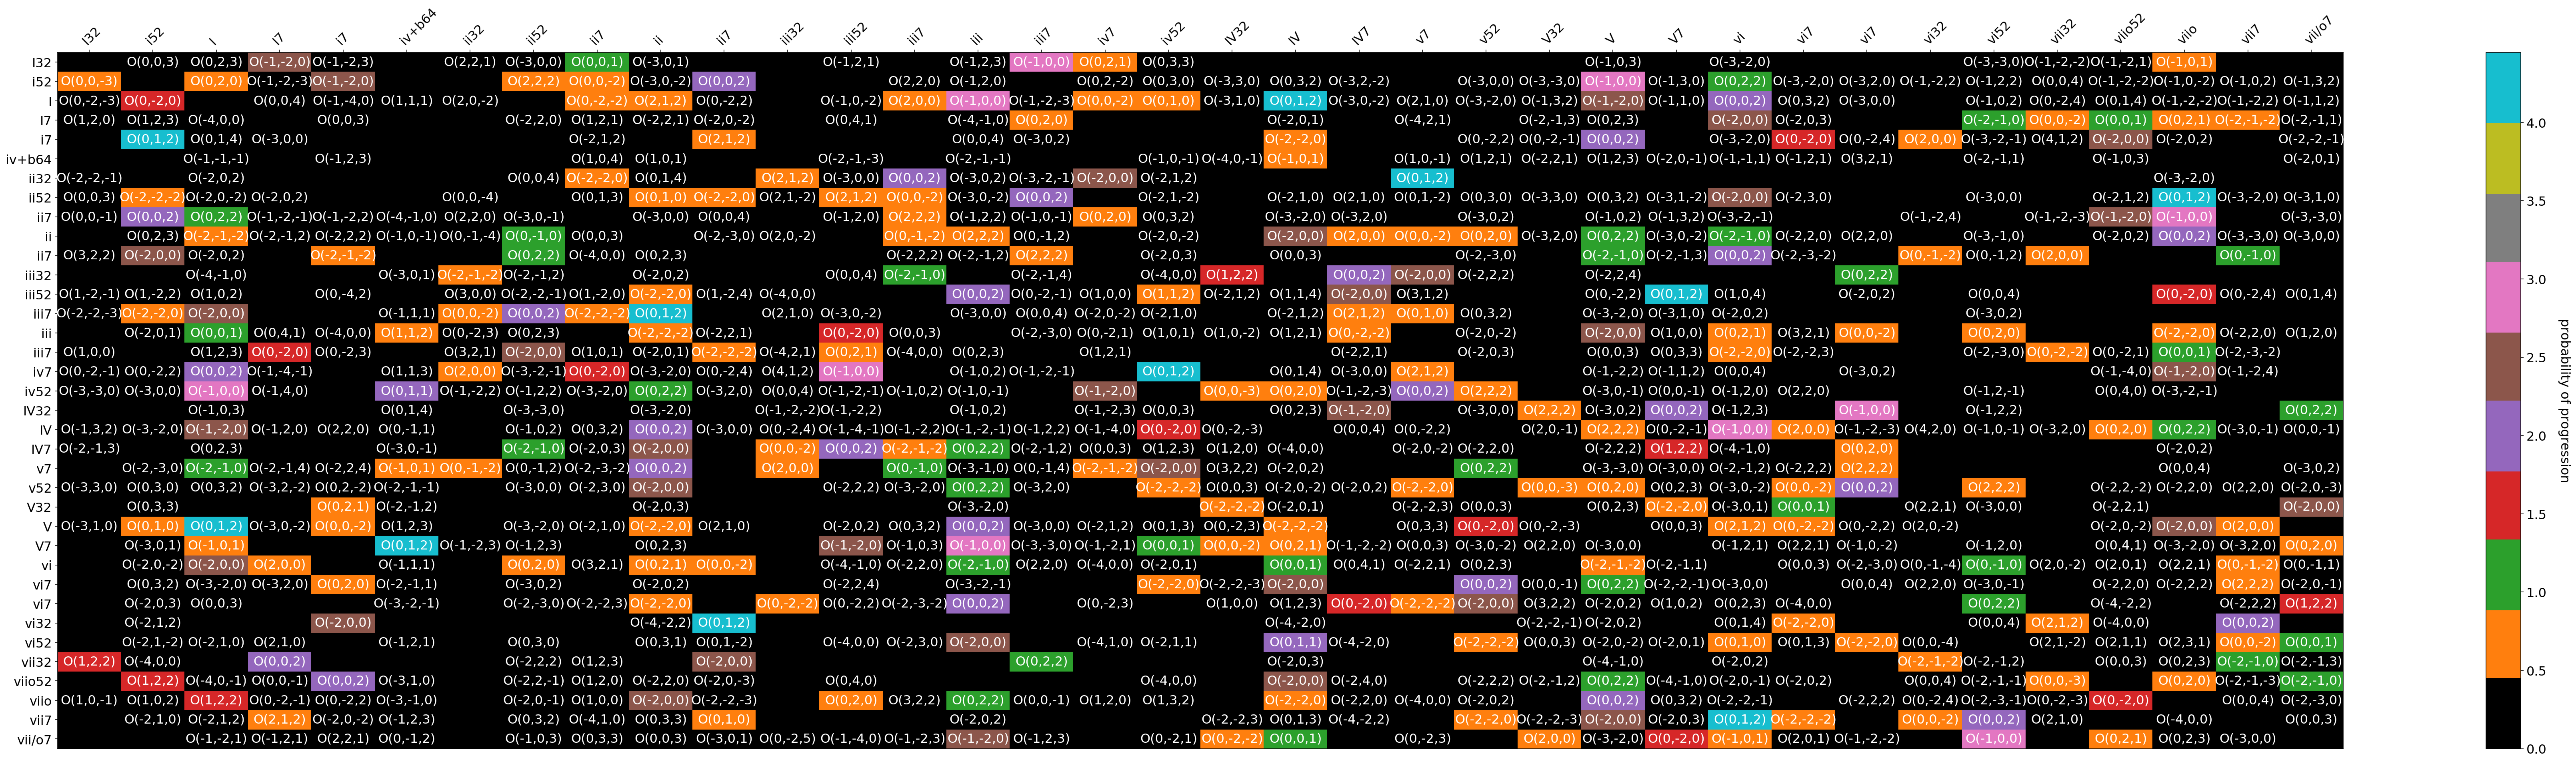

In [10]:
plotHarmonicTable(Maj_headers,Maj_table,Pnumber,height=16,width=64,colmap=newcmp)

In [13]:
Maj_table

[['I32',
  'O(0,0,0)',
  'O(0,0,3)',
  'O(0,2,3)',
  'O(-1,-2,0)',
  'O(-1,-2,3)',
  'O(-4,-1,1)',
  'O(2,2,1)',
  'O(-3,0,0)',
  'O(0,0,1)',
  'O(-3,0,1)',
  'O(-3,-2,-2)',
  'O(-5,2,1)',
  'O(-1,2,1)',
  'O(2,2,3)',
  'O(-1,2,3)',
  'O(-1,0,0)',
  'O(0,2,1)',
  'O(0,3,3)',
  'O(-3,3,3)',
  'O(-3,-2,1)',
  'O(-3,2,1)',
  'O(2,3,3)',
  'O(-3,0,3)',
  'O(-3,-3,3)',
  'O(-1,0,3)',
  'O(-1,3,3)',
  'O(-3,-2,0)',
  'O(-3,-2,3)',
  'O(-3,2,3)',
  'O(-1,-2,5)',
  'O(-3,-3,0)',
  'O(-1,-2,-2)',
  'O(-1,-2,1)',
  'O(-1,0,1)',
  'O(-3,-3,-2)',
  'O(-3,-3,1)'],
 ['i52',
  'O(0,0,-3)',
  'O(0,0,0)',
  'O(0,2,0)',
  'O(-1,-2,-3)',
  'O(-1,-2,0)',
  'O(1,3,1)',
  'O(2,2,-2)',
  'O(2,2,2)',
  'O(0,0,-2)',
  'O(-3,0,-2)',
  'O(0,0,2)',
  'O(4,3,0)',
  'O(-1,2,-2)',
  'O(2,2,0)',
  'O(-1,2,0)',
  'O(-1,0,-3)',
  'O(0,2,-2)',
  'O(0,3,0)',
  'O(-3,3,0)',
  'O(0,3,2)',
  'O(-3,2,-2)',
  'O(2,3,0)',
  'O(-3,0,0)',
  'O(-3,-3,0)',
  'O(-1,0,0)',
  'O(-1,3,0)',
  'O(0,2,2)',
  'O(-3,-2,0)',
  'O(-3,2,0)',


#### Triadic harmony - minor mode

In [ ]:
# minor scale triads

min_triads = []
# natural minor
a = np.array([0,2,3,5,7,8,10])
natural,_ = pcsDictionary(3,order=1,row=True,a=a)
natural = natural['pcs'].tolist()
for n in range(len(natural)):
    min_triads.append(str2float(natural[n])[0].tolist())
    
# harmonic minor
a = np.array([0,2,3,5,7,8,11])
harmonic,_ = pcsDictionary(3,order=1,row=True,a=a)
harmonic = harmonic['pcs'].tolist()
for n in range(len(harmonic)):
    min_triads.append(str2float(harmonic[n])[0].tolist())

# melodic minor
a = np.array([0,2,3,5,7,9,11])
melodic,_ = pcsDictionary(3,order=1,row=True,a=a)
melodic = melodic['pcs'].tolist()
for n in range(len(melodic)):
    min_triads.append(str2float(melodic[n])[0].tolist())

# add I for Picardy 3rd
min_triads.append([0,4,7])

# put triads in root position (for roman numeral determination)
for m in range(len(min_triads)):
    n = m21.chord.Chord(min_triads[m])
    r = n.root()
    if n[0].name != r.name:
        c = []
        for i in range(len(n)):
            n = m21.chord.Chord(np.roll(n,-1))
            if n[0].name == r.name: 
                for j in range(len(n)):
                    c.append(n.pitches[j].pitchClass)
                break    
        min_triads[m] = c

In [ ]:
    
# eliminate duplicates
res = [] 
for i in min_triads: 
    if i not in res: 
        res.append(i) 
min_triads = sorted(res)

# make dictionary of chord names
min_name_dict = {}
for i in range(len(min_triads)):
    min_name_dict.update({i:0})

for i in range(len(min_triads)):
    ch = np.copy(min_triads[i])
    for n in range(1,len(ch)):
        if ch[n] < ch[n-1]: ch[n] += 12
    ch += 60
    no = []
    for n in ch:
        no.append(notedict[n])
    n = m21.chord.Chord(no)
#     n = m21.chord.Chord(ch.tolist())
    rn = m21.roman.romanNumeralFromChord(n, m21.key.Key('c'))
    min_name_dict.update({i:str(rn.figure)})

# make table of operators
min_table = []
for n in range(len(min_triads)):
    mat = [min_name_dict[n]]
    for m in range(len(min_triads)):
        _,m = generalizedOpsName(min_triads[n],min_triads[m])
        mat.append(m)
    min_table.append(mat)
min_headers = ['minor']
for n in range(1,len(min_name_dict)+1):
    min_headers.append(min_name_dict[n-1])

In [ ]:
WRITEscoreOps(min_triads,keysig='c',w=True)

In [ ]:
print(tabulate(min_table, min_headers, tablefmt='tsv'))

In [ ]:
plotHarmonicTable(min_headers,min_table,Pnumber,height=24,width=36,colmap=newcmp,label=True,star='x')

In [ ]:
lookupOps('O(1,2,3)',Maj_table,Maj_headers,Pnumber)

#### Major quadrichordal harmony

In [ ]:
# Major scale quadrichords

a = np.array([0,2,4,5,7,9,11])

quads,_ = pcsDictionary(4,order=1,row=True,a=a)

quads = quads['pcs'].tolist()

Maj_quads = []
for n in range(len(quads)):
    Maj_quads.append(str2float(quads[n])[0].tolist())

# add triads
for i,n in enumerate(Maj_triads):
    Maj_quads.append(Maj_triads[i])

# put triads in root position (for roman numeral determination)
for m in range(len(Maj_quads)):
    n = m21.chord.Chord(Maj_quads[m])
    r = n.root()
    if n[0].name != r.name:
        c = []
        for i in range(len(n)):
            n = m21.chord.Chord(np.roll(n,-1))
            if n[0].name == r.name: 
                for j in range(len(n)):
                    c.append(n.pitches[j].pitchClass)
                break    
        Maj_quads[m] = c

In [ ]:
# eliminate duplicates
res = [] 
for i in Maj_quads: 
    if i not in res: 
        res.append(i) 
Maj_quads = sorted(res)
# Maj_quads = res

In [ ]:
# add diminished seventh
Maj_quads.append([11,2,5,8])
Maj_quads.append([0,3,6,9])
Maj_quads.append([1,4,7,10])
# add half-diminished seventh on V
Maj_quads.append([7,10,1,5])
# add minor seventh on I
Maj_quads.append([0,4,7,10])

Maj_quads.append(['#############'])

In [ ]:
# make dictionary of chord names
Majq_name_dict = {}
for i in range(len(Maj_quads)):
    Majq_name_dict.update({i:0})

for i in range(len(Maj_quads)):
    ch = np.copy(Maj_quads[i])
    for n in range(1,len(ch)):
        if ch[n] < ch[n-1]: ch[n] += 12
    ch += 60
    no = []
    for n in ch:
        no.append(notedict[n])
    n = m21.chord.Chord(no)
#     n = m21.chord.Chord(ch.tolist())
    rn = m21.roman.romanNumeralFromChord(n, m21.key.Key('C'))
    Majq_name_dict.update({i:str(rn.figure)})

# make table of operators
Majq_table = []
for n in range(len(Maj_quads)):
    mat = [Majq_name_dict[n]]
    for m in range(len(Maj_quads)):
        _,m = generalizedOpsName(Maj_quads[n],Maj_quads[m])
        mat.append(m)
    Majq_table.append(mat)
Majq_headers = ['Major']
for n in range(1,len(Majq_name_dict)+1):
    Majq_headers.append(Majq_name_dict[n-1])

In [ ]:
Maj_quads[76]

In [ ]:
WRITEscoreOps(Maj_quads,notedict,keysig='C',w=True)

In [ ]:
print(tabulate(Majq_table, Majq_headers, tablefmt='tsv'))

In [ ]:
plotHarmonicTable(Majq_headers,Majq_table,Pnumber,height=24,width=36,colmap=newcmp,label=True,star='x')

In [ ]:
f = open('Major.harmony','wb')
pickle.dump(Majq_headers,f)
pickle.dump(Majq_table,f)
f.close()

In [ ]:
lookupProgr('vii/o7','IV532',Majq_table,Majq_headers)

In [ ]:
lookupOps('O(0,0,0,-2)',Majq_table,Majq_headers)

In [ ]:
# minor scale quadrichords

min_quads = []
# natural minor
a = np.array([0,2,3,5,7,8,10])
natural,_ = pcsDictionary(4,order=1,row=True,a=a)
natural = natural['pcs'].tolist()
for n in range(len(natural)):
    min_quads.append(str2float(natural[n])[0].tolist())
    
# harmonic minor
a = np.array([0,2,3,5,7,8,11])
harmonic,_ = pcsDictionary(4,order=1,row=True,a=a)
harmonic = harmonic['pcs'].tolist()
for n in range(len(harmonic)):
    min_quads.append(str2float(harmonic[n])[0].tolist())

# melodic minor
a = np.array([0,2,3,5,7,9,11])
melodic,_ = pcsDictionary(4,order=1,row=True,a=a)
melodic = melodic['pcs'].tolist()
for n in range(len(melodic)):
    min_quads.append(str2float(melodic[n])[0].tolist())

# add triads
for i,n in enumerate(min_triads):
    min_quads.append(min_triads[i])

# put quadrichords in root position (for roman numeral determination)
for m in range(len(min_quads)):
    n = m21.chord.Chord(min_quads[m])
    r = n.root()
    if n[0].name != r.name:
        c = []
        for i in range(len(n)):
            n = m21.chord.Chord(np.roll(n,-1))
            if n[0].name == r.name: 
                for j in range(len(n)):
                    c.append(n.pitches[j].pitchClass)
                break    
        min_quads[m] = c

In [ ]:
# add diminished seventh (incomplete vo9)
min_quads.append([11,2,5,8])
min_quads.append([0,3,6,9])
min_quads.append([1,4,7,10])
# add half-diminished seventh on V
min_quads.append([7,10,1,5])
# add minor seventh on I
min_quads.append([0,4,7,10])
min_quads.append('###########')

# # total harmonic space
# for n in range(len(Maj_quads)):
#     min_quads.append(Maj_quads[n])
        

In [ ]:
# eliminate duplicates
res = [] 
for i in min_quads: 
    if i not in res: 
        res.append(i) 
# min_quads = res
min_quads = sorted(res)

In [ ]:
WRITEscoreOps(min_quads,notedict,keysig='c',w=True)

In [ ]:
# make dictionary of chord names
minq_name_dict = {}
for i in range(len(min_quads)):
    minq_name_dict.update({i:0})

for i in range(len(min_quads)):
    ch = np.copy(min_quads[i])
    for n in range(1,len(ch)):
        if ch[n] < ch[n-1]: ch[n] += 12
    ch += 60
    no = []
    for n in ch:
        no.append(notedict[n])
    n = m21.chord.Chord(no)
#     n = m21.chord.Chord(ch.tolist())
    rn = m21.roman.romanNumeralFromChord(n, m21.key.Key('c'))
    minq_name_dict.update({i:str(rn.figure)})

# make table of operators
minq_table = []
for n in range(len(min_quads)):
    mat = [minq_name_dict[n]]
    for m in range(len(min_quads)):
        _,m = generalizedOpsName(min_quads[n],min_quads[m])
        mat.append(m)
    minq_table.append(mat)
minq_headers = ['minor']
for n in range(1,len(minq_name_dict)+1):
    minq_headers.append(minq_name_dict[n-1])

In [ ]:
plotHarmonicTable(minq_headers,minq_table,Pnumber,height=42,width=54,colmap=newcmp,label=True,star='x')

In [ ]:
f = open('total.harmony','wb')
pickle.dump(minq_headers,f)
pickle.dump(minq_table,f)
f.close()

## Definition of chords and roman numeral symbols following the convention in
### The Annotated Beethoven Corpus (ABC): A Dataset of Harmonic Analyses of All Beethoven String Quartets Markus Neuwirth*, Daniel Harasim, Fabian C. Moss and Martin Rohrmeier
## Frontier in Digital Humanities, doi: 10.3389/fdigh.2018.00016

In [ ]:
# roman numeral classes - full
rnlist_m = ['bi', 'i', '#i', 'bii', 'ii', '#ii', 'biii', 'iii', '#iii', 'biv', 'iv', '#iv', 'bv', 'v', '#v', 'bvi', 'vi', '#vi', 'bvii', 'vii', '#vii'] 
rnlist_M = ['bI', 'I', '#I', 'bII', 'II', '#II', 'bIII', 'III', '#III', 'bIV', 'IV', '#IV','bV', 'V', '#V', 'bVI', 'VI', '#VI','bVII', 'VII', '#VII']
dimlist = ['/o','o','/o7','o7']
auglist = ['+']
suslist = ['52']
extlist = ['7','b7','#7','7#43']

In [ ]:
# roman numeral classes - minimal
rnlist_m = ['i', 'ii', 'biii', 'iii', 'iv', 'v', 'vi', 'bvii', 'vii'] 
rnlist_M = ['I', 'II', 'bIII', 'III', 'IV', 'V', 'VI', 'bVII', 'VII']
dimlist = ['/o','o','/o7','o7']
auglist = ['+']
suslist = ['52']
extlist = ['7','b7','#7','7#43']

In [ ]:
# build the composite numerals and the corresponding pcs

seq = []
rn = []

# minor triads
for c in rnlist_m:
    chd = m21.roman.RomanNumeral(c)
    seq.append(chd.pitchClasses)
    rn.append(c)
# major triads
for c in rnlist_M:
    chd = m21.roman.RomanNumeral(c)
    seq.append(chd.pitchClasses)
    rn.append(c)
# diminished
for c in rnlist_m:
    for d in dimlist:
        f = c+d
        chd = m21.roman.RomanNumeral(f)
        seq.append(chd.pitchClasses)
        rn.append(f)
# sus triads
for c in rnlist_m:
    f = c+suslist[0]
    chd = m21.roman.RomanNumeral(f)
    seq.append(chd.pitchClasses)
    rn.append(f)
# augmented triads
for c in rnlist_M:
    for d in auglist:
        f = c+d
        chd = m21.roman.RomanNumeral(f)
        seq.append(chd.pitchClasses)
        rn.append(f)
# minor quadrichords
for c in rnlist_m:
    for d in extlist:
        f = c+d
        chd = m21.roman.RomanNumeral(f)
        seq.append(chd.pitchClasses)
        rn.append(f)
# major quadrichords
for c in rnlist_M:
    for d in extlist:
        f = c+d
        chd = m21.roman.RomanNumeral(f)
        seq.append(chd.pitchClasses)
        rn.append(f)
# augmented quadrichords
for c in rnlist_M:
    for d in extlist:
        f = c+auglist[0]+d
        chd = m21.roman.RomanNumeral(f)
        seq.append(chd.pitchClasses)
        rn.append(f)

In [ ]:
# make table of operators
opstable = []
for n in range(len(seq)):
    mat = []
    for m in range(len(seq)):
        _,m = generalizedOpsName(seq[n],seq[m])
        mat.append(m)
    opstable.append(mat)

In [ ]:
f = open('tonal.harmony.minimal','wb')
pickle.dump(rn,f)
pickle.dump(opstable,f)
f.close()

In [ ]:
target = [6,8,0,2]
for i in range(len(seq)):
    if seq[i] == target:
        print(seq[i],rn[i])

In [ ]:
len(seq)

In [ ]:
table = opstable

In [ ]:
table.insert(0,rn)

In [ ]:
f = open('Pnumber.LvB','rb')
Pnumber = pickle.load(f)
f.close()

In [ ]:
plotHarmonicTable(rn,table,Pnumber,height=42,width=54,colmap=newcmp,label=True,star='x')